In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


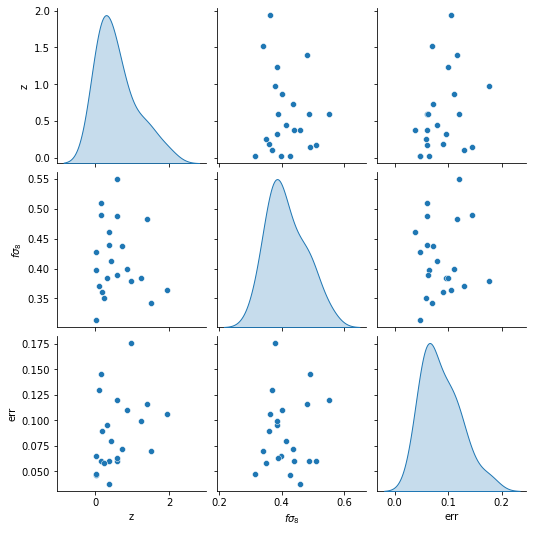

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 100

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0211
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0136
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0136
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 11/

17/17 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 83/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 84/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 85/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 86/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 87/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 88/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 89/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 90/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 91/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 92/100


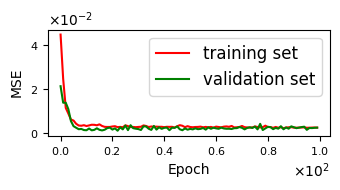

In [13]:
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# # plt.xscale('log')
# plt.xlim(0)
# plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)
plt.figure(figsize=(3.5, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.tight_layout()

plt.savefig('loss_fs8_corr.png')




In [14]:
# neural_model.save("FFNN_fs8_correction.h5")

In [15]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016
dif_loss = model_train.history['val_loss'][-1] - model_train.history['val_loss'][-2]
val_loss = model_train.history['val_loss'][-1]
dif_loss, val_loss

0.001977509120479226 0.0008323251968249679
0.0022393555846065283 0.0022274889051914215


(5.922606214880943e-05, 0.0022274889051914215)

In [16]:
pred = neural_model.predict(z_test)
pred

array([[0.46842563, 0.05679028],
       [0.46100247, 0.09213083],
       [0.44207263, 0.10061306],
       [0.43576586, 0.10254236],
       [0.41346568, 0.11581363]], dtype=float32)

In [17]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [18]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


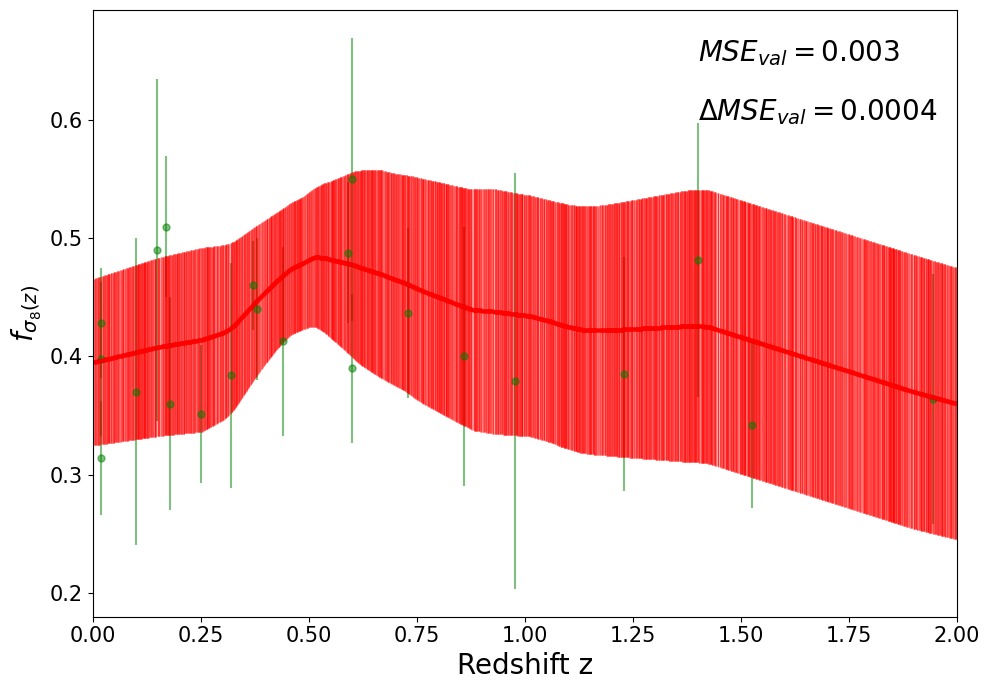

In [19]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.1, c='r',)
plt.ylabel("$f_{\sigma_8(z)}$", fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.text( 1.4, 0.65, "$MSE_{val} = 0.003$", fontsize=20 )
plt.text( 1.4, 0.6, "$\Delta MSE_{val} = 0.0004$", fontsize=20 )
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.legend(loc='upper right')
# plt.legend()
# plt.savefig("synthetic_fs8_1000.png")

In [20]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1
# def Ezlcdm(a):
#     return np.sqrt(Om*(1/a)**3 + 1 - Om)

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
# #     return Om*(1/a)**3 + 1 - Om
#     w0 = -1.0
#     wa = 0.0
#     rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
#     return (Om/a**3+(1.0-Om)*rhow)

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

  
# def growth_lcdm(z):
#     # Equation 7.77 from Doddie
#     af = 1./(1. + z)
#     r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
#     gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
#     gr *= 5/2.*Om
#     return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# # returns the growth factor as a function of redshift
# def GrowthIntegrand_a_lcdm(a):
#     rhsquareda = RHSquared_a_lcdm(a) 
#     return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

# def fs8lcdm(z):
#     return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [21]:
z = np.linspace(0.0, 2, 1000)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8,wa=-0.13))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)

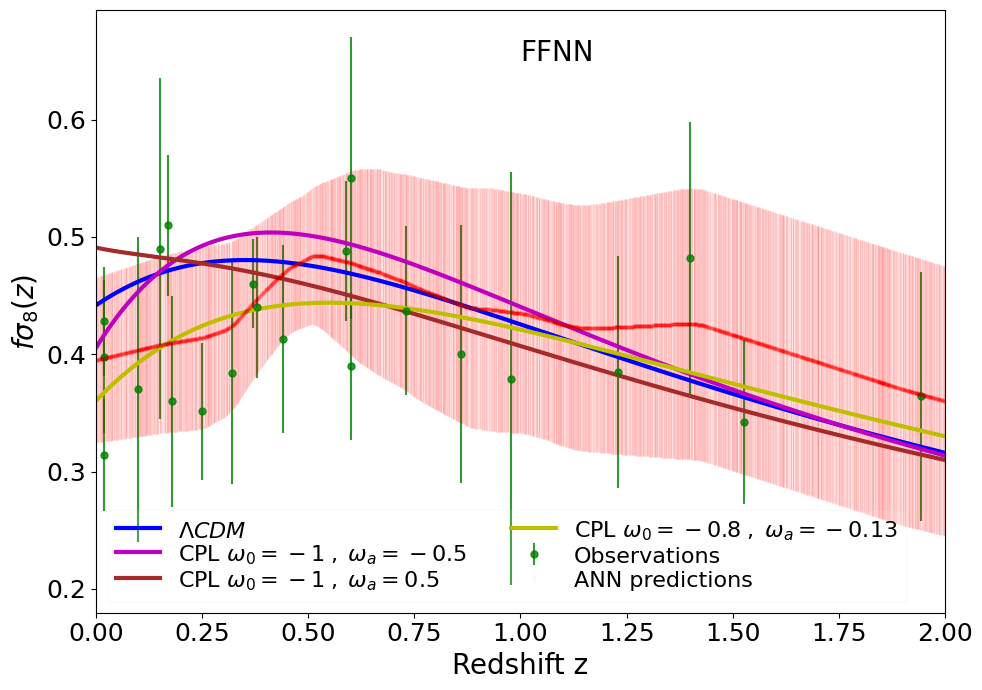

In [44]:
plt.figure(figsize=(10, 7), dpi=100)

z = np.linspace(0, 2, 1000)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='ANN predictions', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.02, c='r',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b', linewidth=3)
plt.plot(z, fowacdm1, label='CPL $\omega_0 = -1 \;,\; \omega_a=-0.5$', c='m', linewidth=3)
plt.plot(z, fowacdm2, label='CPL $\omega_0 = -1 \;,\; \omega_a=0.5$', c='brown', linewidth=3)
plt.plot(z, fowacdm3, label='CPL $\omega_0 =-0.8 \;,\; \omega_a=-0.13$', c='y', linewidth=3)
plt.text(1,0.65,'FFNN', fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)

legend = plt.legend(loc='lower left', fontsize=16, ncol=2, handleheight=1.2, labelspacing=0.05)
legend.get_frame().set_alpha(0.1)

plt.tight_layout()

plt.savefig("Syntheticfs8_correction.png")

In [23]:
# pred_random.shape, r.shape

In [24]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [25]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [26]:
mookHz

array([[1.32688244, 0.42475885, 0.11267237],
       [0.95109856, 0.437051  , 0.10316411],
       [1.03093019, 0.43247563, 0.10213889],
       [1.23826545, 0.42306417, 0.1085169 ],
       [1.40284002, 0.4257282 , 0.11553837],
       [0.50060675, 0.48182726, 0.05721187],
       [1.67477888, 0.39620668, 0.11589572],
       [0.44657141, 0.47053218, 0.05640401],
       [0.3500436 , 0.43544567, 0.06778985],
       [1.99459205, 0.3606407 , 0.11496483],
       [1.15914018, 0.42223334, 0.10520594],
       [0.03209727, 0.39773399, 0.07149474],
       [0.79803324, 0.45065254, 0.09720258],
       [1.30537497, 0.42434621, 0.11166403],
       [0.17008104, 0.40914381, 0.07587294],
       [0.13039589, 0.4061994 , 0.07479642],
       [1.92035128, 0.36805356, 0.11578329],
       [1.93320078, 0.36675894, 0.11564507],
       [1.48364684, 0.41837883, 0.11579023],
       [1.29761145, 0.42419726, 0.11130005],
       [0.33129523, 0.42780167, 0.0705145 ],
       [0.93169242, 0.43799013, 0.10359243],
       [0.

In [27]:
predy_reduced[:,1]

array([0.11267237, 0.10316411, 0.10213889, 0.1085169 , 0.11553837,
       0.05721187, 0.11589572, 0.05640401, 0.06778985, 0.11496483,
       0.10520594, 0.07149474, 0.09720258, 0.11166403, 0.07587294,
       0.07479642, 0.11578329, 0.11564507, 0.11579023, 0.11130005,
       0.0705145 , 0.10359243, 0.07593386, 0.0935313 , 0.10585304,
       0.06456389, 0.05581884, 0.1007386 , 0.07057045, 0.1035597 ,
       0.10235563, 0.11582805, 0.10362728, 0.115894  , 0.11591682,
       0.06513   , 0.06940588, 0.1159119 , 0.11546619, 0.09732766,
       0.07985455, 0.11600053, 0.10003051, 0.1004539 , 0.06158401,
       0.10497421, 0.07056524, 0.115926  , 0.07159442, 0.07669236],
      dtype=float32)

In [28]:
error  = predy_reduced[:,1]**2
error

array([0.01269506, 0.01064283, 0.01043235, 0.01177592, 0.01334912,
       0.0032732 , 0.01343182, 0.00318141, 0.00459546, 0.01321691,
       0.01106829, 0.0051115 , 0.00944834, 0.01246885, 0.0057567 ,
       0.0055945 , 0.01340577, 0.01337378, 0.01340738, 0.0123877 ,
       0.00497229, 0.01073139, 0.00576595, 0.0087481 , 0.01120486,
       0.0041685 , 0.00311574, 0.01014827, 0.00498019, 0.01072461,
       0.01047667, 0.01341614, 0.01073861, 0.01343142, 0.01343671,
       0.00424192, 0.00481718, 0.01343557, 0.01333244, 0.00947267,
       0.00637675, 0.01345612, 0.0100061 , 0.01009099, 0.00379259,
       0.01101958, 0.00497945, 0.01343884, 0.00512576, 0.00588172],
      dtype=float32)

In [29]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

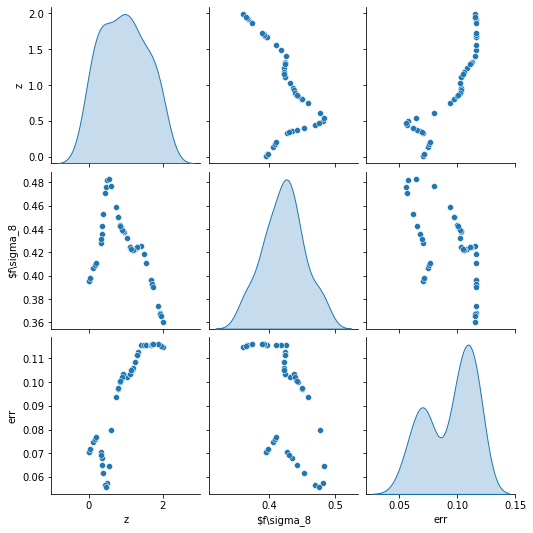

In [30]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [31]:
from astroNN.nn.layers import MCDropout

In [32]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((800,), (22, 1), (200,), (0, 1))

In [33]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2000
5/5 [==============================] - 0s 25ms/step - loss: 0.1093 - val_loss: 0.1024
Epoch 2/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.1028 - val_loss: 0.0902
Epoch 3/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.1029 - val_loss: 0.0786
Epoch 4/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.1032 - val_loss: 0.0800
Epoch 5/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0912 - val_loss: 0.0731
Epoch 6/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0888 - val_loss: 0.0767
Epoch 7/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0813 - val_loss: 0.0780
Epoch 8/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0750 - val_loss: 0.0663
Epoch 9/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0631 - val_loss: 0.0633
Epoch 10/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0679 - val_loss: 0.0659
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0087
Epoch 85/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0078
Epoch 86/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0127 - val_loss: 0.0073
Epoch 87/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 88/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0093 - val_loss: 0.0071
Epoch 89/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0105
Epoch 90/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0168
Epoch 91/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0079 - val_loss: 0.0116
Epoch 92/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 93/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0088
Epoch 94/2

5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 167/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 168/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 169/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 170/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 171/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 172/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 173/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 174/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 175/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 176/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 249/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 250/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 251/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 252/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 253/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 254/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0043
Epoch 255/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 256/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 257/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 258/2000


5/5 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 331/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 332/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 333/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 334/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 335/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 336/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 337/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 338/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 339/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 340/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 413/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 414/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 415/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 416/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 417/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 418/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 419/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 420/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 421/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 422/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 495/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 496/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 497/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 498/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 499/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0089
Epoch 500/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 501/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0054
Epoch 502/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 503/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 504/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 577/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 578/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 579/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 580/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 581/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 582/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 583/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 584/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 585/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 586/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 659/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 660/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 661/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 662/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 663/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 664/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 665/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 666/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 667/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 668/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 741/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 742/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 743/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 744/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 745/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 746/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 747/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 748/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 749/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 750/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 823/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 824/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 825/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 826/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 827/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 828/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 829/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 830/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 831/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 832/2000


5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 905/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 906/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 907/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 908/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 909/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 910/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 911/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 912/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 913/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 914/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 987/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 988/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 989/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 990/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 991/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 992/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 993/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 994/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 995/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 996/2000


5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 1068/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 1069/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 1070/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 1071/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1072/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 1073/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 1074/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 1075/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1076/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 1149/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 1150/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 1151/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 1152/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1153/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1154/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 1155/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 1156/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 1157/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 

Epoch 1229/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 1230/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 1231/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 1232/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 1233/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 1234/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 1235/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 1236/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 1237/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 1238/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_los

5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 1311/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 1312/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 1313/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1314/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1315/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 1316/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 1317/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 1318/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 1319/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1392/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 1393/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 1394/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1395/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 1396/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 1397/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 1398/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 1399/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 1400/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 1473/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1474/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 1475/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 1476/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1477/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 1478/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 1479/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 1480/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 1481/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 1554/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 1555/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 1556/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 1557/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 1558/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 1559/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 1560/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 1561/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 1562/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 1635/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 1636/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 1637/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1638/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 1639/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 1640/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 1641/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 1642/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 1643/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1716/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 1717/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 1718/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 1719/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 1720/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 1721/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 1722/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1723/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 1724/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 

Epoch 1796/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 1797/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 1798/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 1799/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 1800/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 1801/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 1802/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1803/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1804/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1805/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_los

5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 1878/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 1879/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 1880/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1881/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 1882/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 1883/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 1884/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 1885/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 1886/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 

Epoch 1958/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 1959/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 1960/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1961/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 1962/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1963/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 1964/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 1965/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 1966/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 1967/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_los

In [34]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [35]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.027985492123070343, 0.01463997072159043)

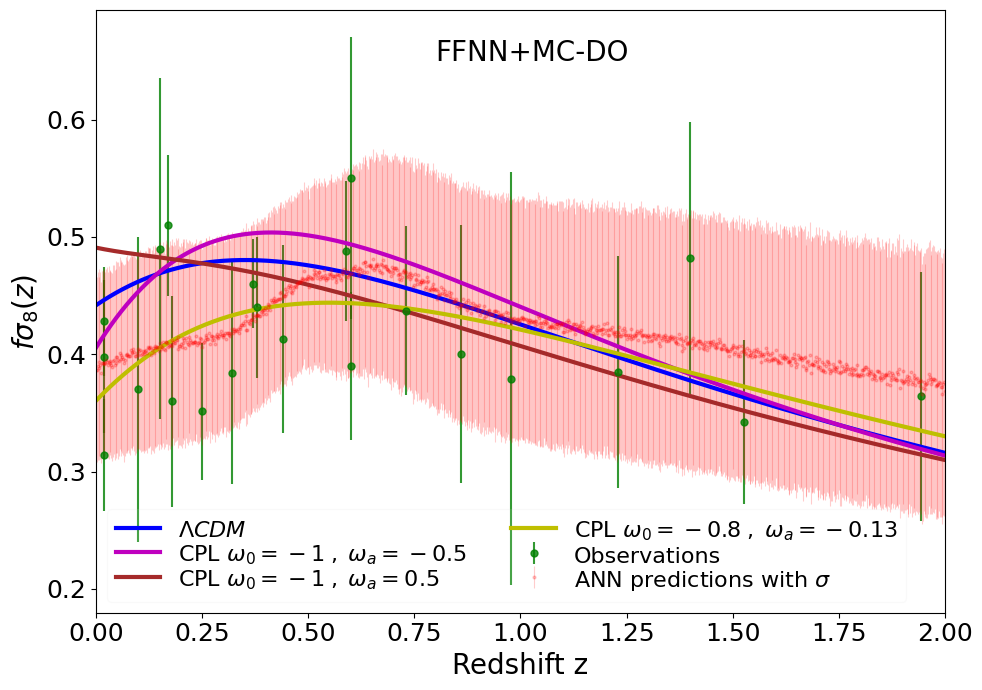

In [43]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',
             label='ANN predictions with $\sigma$')




plt.plot(z, flcdm, label='$\Lambda CDM$', c='b', linewidth=3)
plt.plot(z, fowacdm1, label='CPL $\omega_0 = -1 \;,\; \omega_a=-0.5$', c='m', linewidth=3)
plt.plot(z, fowacdm2, label='CPL $\omega_0 = -1 \;,\; \omega_a=0.5$', c='brown', linewidth=3)
plt.plot(z, fowacdm3, label='CPL $\omega_0 =-0.8 \;,\; \omega_a=-0.13$', c='y', linewidth=3)
plt.text(0.8,0.65,'FFNN+MC-DO', fontsize=20)
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("$f\sigma_8(z)$", fontsize=20)

legend = plt.legend(loc='lower left', fontsize=16, ncol=2, handleheight=1.2, labelspacing=0.05)
legend.get_frame().set_alpha(0.1)

plt.tight_layout()
plt.savefig('fs8_dropoutb_correction.png')

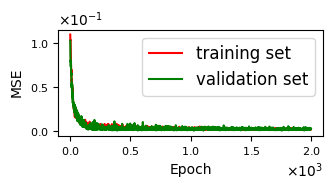

In [37]:
plt.figure(figsize=(3.5, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.tight_layout()
plt.savefig('loss_fs8_DO_corr.png')

In [38]:
# tf.keras.models.save_model(model2, '../models/FFNN_MC_DO_fs8_correction.h5' )

In [39]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [40]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

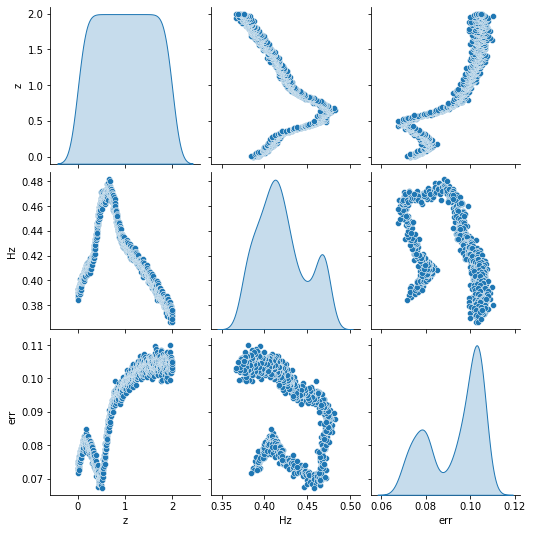

In [41]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")